In [94]:
import pandas as pd
from pedigree_tools import Pedigree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from Ponderosa import *
import pickle as pkl
from collections import Counter

In [84]:
def genotyped_parent(id1, id2, samples, hs):
    if hs:
        parents1 = {samples.g.nodes[id1][i] for i in ["father", "mother"]} - {-1}
        parents2 = {samples.g.nodes[id2][i] for i in ["father", "mother"]} - {-1}
        parent = next(iter(parents1&parents2))
        return samples.g.get_edge_data(id1, parent, {}).get("k_ibd1", 0) > 0
    else:
        return samples.g.nodes[id1]["father"] != -1 or samples.g.nodes[id1]["mother"] != -1 



In [2]:
samples1 = SampleData(fam_file="for_dev/BAGS/BAGS_KINGPO.fam",
                     king_file="for_dev/BAGS/BAGS.seg",
                     ibd_file="for_dev/BAGS/BAGS_phasedibd.txt")

No population file has been provided.
No age data has been provided.
No map files have been provided. Assuming genome length of 3545 cM.
Processing IBD segments...


In [3]:
i = open("for_dev/BAGS/bags_wgs_debug_samples.pkl", "rb")
samples2 = pkl.load(i)

In [4]:
pedigree = Pedigree(samples=samples1, pedigree_file="pedigree_codes.yaml", tree_file="tree_codes.yaml")
pairs1 = pedigree.find_all_relationships()

pedigree = Pedigree(samples=samples2, pedigree_file="pedigree_codes.yaml", tree_file="tree_codes.yaml")
pairs2 = pedigree.find_all_relationships()

In [101]:
second1 = pairs1.get_pair_df_from(["MHS", "PHS", "AV", "PGP", "MGP"]).dropna()
second1["gt_parent"] = second1.apply(lambda x: genotyped_parent(*x.pair, samples1, "HS" in x.requested), axis=1)

second2 = pairs2.get_pair_df_from(["MHS", "PHS", "AV", "PGP", "MGP"]).dropna()
second2["gt_parent"] = second2.apply(lambda x: genotyped_parent(*x.pair, samples2, "HS" in x.requested), axis=1)

second1["dataset"] = "old"
second2["dataset"] = "new"

second = pd.concat([second1, second2])

In [100]:
for df, df_lab in zip([second1, second2], ["old", "new"]):
    print(df_lab, "all", Counter(df["requested"]))
    for boo in [True, False]:
        print(df_lab, boo, Counter(df[df.gt_parent==boo]["requested"]))

old all Counter({'AV': 174, 'MHS': 71, 'MGP': 65, 'PGP': 27, 'PHS': 6})
old True Counter({'AV': 174, 'MHS': 71, 'MGP': 65, 'PGP': 27, 'PHS': 6})
old False Counter()
new all Counter({'AV': 268, 'MHS': 165, 'MGP': 145, 'PGP': 47, 'PHS': 21})
new True Counter({'AV': 268, 'MGP': 145, 'MHS': 127, 'PGP': 47, 'PHS': 20})
new False Counter({'MHS': 38, 'PHS': 1})


Text(0, 0.5, 'haplotype score')

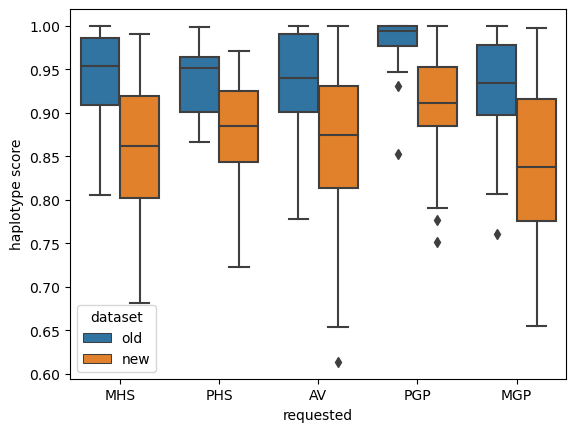

In [106]:
second["h_exp1"] = second.apply(lambda x: [j for _,j in x.h.items()][0] if "HS" in x.requested else x.h[x.pair[0]], axis=1)

sns.boxplot(data=second, x="requested", y="h_exp1", hue="dataset")

plt.ylabel("haplotype score")

Text(0, 0.5, 'Number of IBD segments shared')

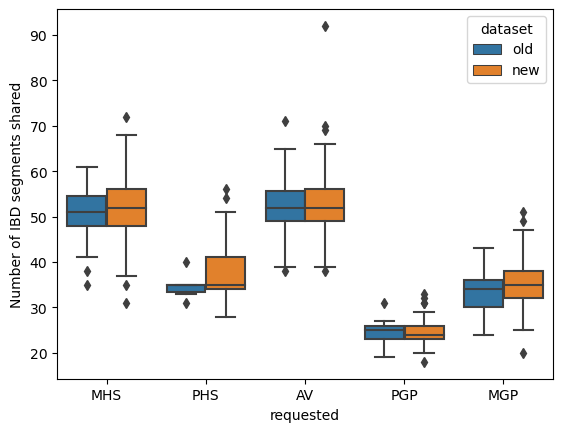

In [108]:
sns.boxplot(data=second, x="requested", y="n", hue="dataset")

plt.ylabel("Number of IBD segments shared")

<AxesSubplot:xlabel='h1', ylabel='h2'>

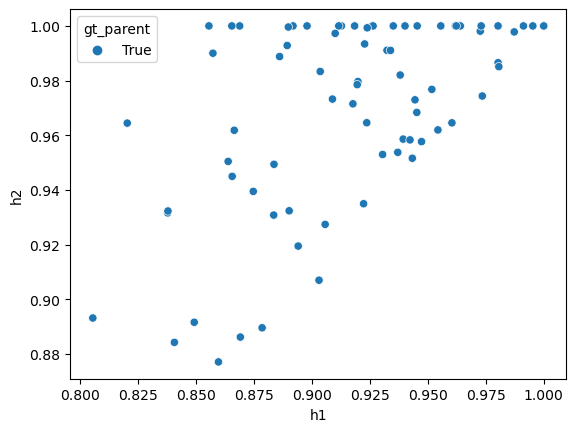

In [63]:
sns.scatterplot(data=hs1, x="h1", y="h2", hue="gt_parent")